# ОИАД. Лабораторная работа №4

Вариант 6: целевая переменная - `study_form`

## Задачи:
1. Тривиальный классификатор
2. Наивный байесовский классификатор (реализовать самому)
3. Метод k-ближайших соседей (реализовать самому)
4. Логистическая регрессия (реализовать самому)
5. Оценка качества всех моделей


## Импорт библиотек


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, f1_score
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 1. Подготовка данных


In [ ]:
df = pd.read_csv('../datasets/famcs_students.csv')

print("Размерность данных:", df.shape)
print("\nПервые строки:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())


Размерность данных: (127, 25)

Первые строки:
   cource  group                  stream sex   age   ss          interest  \
0       4     11  Прикладная информатика   М  20.0  Нет        Математика   
1       4     11  Прикладная информатика   Ж  20.0  Нет  Программирование   
2       4     11  Прикладная информатика   Ж  19.0  Нет  Программирование   
3       4     11  Прикладная информатика   Ж  20.0  Нет        Математика   
4       4     11  Прикладная информатика   М  20.0  Нет        Математика   

        os weekend_study bad_sleep  ...      social  \
0    MacOS            Да        Да  ...  Экстраверт   
1    MacOS           Нет       Нет  ...  Экстраверт   
2    MacOS            Да       Нет  ...  Экстраверт   
3    MacOS            Да        Да  ...  Экстраверт   
4  Windows            Да       Нет  ...   Интроверт   

                       sport  miss  study_form foot_size eye_color score  \
0  Редко, легкая физкультура   3.0      Бюджет      48.0     Карие   9.2   
1       

In [163]:
target_col = 'study_form'
print(f"Целевая переменная: {target_col}")
print(f"\nРаспределение целевой переменной:")
print(df[target_col].value_counts())
print(f"\nДоля классов:")
print(df[target_col].value_counts(normalize=True))


Целевая переменная: study_form

Распределение целевой переменной:
study_form
Бюджет     94
Платная    33
Name: count, dtype: int64

Доля классов:
study_form
Бюджет     0.740157
Платная    0.259843
Name: proportion, dtype: float64


In [164]:
# Выбор признаков 
binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']

# Исключаем целевую переменную и другие бинарные колонки из признаков
exclude_cols = binary_cols.copy()

# Выбираем числовые и категориальные признаки
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Выбранные признаки ({len(feature_cols)}):")
print(feature_cols)

df_work = df.copy()

# Кодируем категориальные признаки
le_dict = {}
for col in df_work.columns:
    if df_work[col].dtype == 'object' and col not in exclude_cols:
        le = LabelEncoder()
        df_work[col] = le.fit_transform(df_work[col].astype(str))
        le_dict[col] = le

X = df_work[feature_cols].copy()
y = df_work[target_col].copy()

# Кодируем целевую переменную
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
print(f"\nКодирование целевой переменной:")
for i, label in enumerate(le_target.classes_):
    print(f"  {i}: {label}")

print(f"\nРазмерность X: {X.shape}")
print(f"Размерность y: {y_encoded.shape}")


Выбранные признаки (17):
['cource', 'group', 'stream', 'sex', 'age', 'os', 'work_experience', 'ai', 'height', 'social', 'sport', 'miss', 'foot_size', 'eye_color', 'score', 'retake', 'hostel']

Кодирование целевой переменной:
  0: Бюджет
  1: Платная

Размерность X: (127, 17)
Размерность y: (127,)


In [165]:
# Разделение данных: train (70%), validation (15%), test (15%)
# Стратифицированное разделение для сохранения пропорций классов

# Сначала отделяем тестовую выборку (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.15, 
    random_state=42, 
    stratify=y_encoded  # Стратификация по целевому признаку
)

# Затем разделяем оставшиеся данные на train (70%) и validation (15%)
# test_size = 15/85 ≈ 0.1765, чтобы получить 15% от исходных данных
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=15/85,  # 15% от исходных данных
    random_state=42, 
    stratify=y_temp  # Стратификация по целевому признаку
)

print(f"Размер train: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Размер validation: {X_val.shape[0]} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Размер test: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")

# Проверка стратификации: пропорции классов должны сохраняться
print("\nПРОВЕРКА СТРАТИФИКАЦИИ (пропорции классов):")

# Исходное распределение
original_dist = pd.Series(y_encoded).value_counts(normalize=True).sort_index()
print(f"\nИсходное распределение:")
for idx, (class_val, prop) in enumerate(original_dist.items()):
    class_name = le_target.inverse_transform([class_val])[0]
    print(f"  Класс {class_val} ({class_name}): {prop:.4f} ({prop*100:.2f}%)")

# Распределение в train
train_dist = pd.Series(y_train).value_counts(normalize=True).sort_index()
print(f"\nTrain распределение:")
for idx, (class_val, prop) in enumerate(train_dist.items()):
    class_name = le_target.inverse_transform([class_val])[0]
    count = (y_train == class_val).sum()
    print(f"  Класс {class_val} ({class_name}): {prop:.4f} ({prop*100:.2f}%) - {count} образцов")

# Распределение в validation
val_dist = pd.Series(y_val).value_counts(normalize=True).sort_index()
print(f"\nValidation распределение:")
for idx, (class_val, prop) in enumerate(val_dist.items()):
    class_name = le_target.inverse_transform([class_val])[0]
    count = (y_val == class_val).sum()
    print(f"  Класс {class_val} ({class_name}): {prop:.4f} ({prop*100:.2f}%) - {count} образцов")

# Распределение в test
test_dist = pd.Series(y_test).value_counts(normalize=True).sort_index()
print(f"\nTest распределение:")
for idx, (class_val, prop) in enumerate(test_dist.items()):
    class_name = le_target.inverse_transform([class_val])[0]
    count = (y_test == class_val).sum()
    print(f"  Класс {class_val} ({class_name}): {prop:.4f} ({prop*100:.2f}%) - {count} образцов")

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nАбсолютные значения классов:")
print(f"\nРаспределение классов в train:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nРаспределение классов в validation:")
print(pd.Series(y_val).value_counts().sort_index())
print(f"\nРаспределение классов в test:")
print(pd.Series(y_test).value_counts().sort_index())


Размер train: 88 (69.3%)
Размер validation: 19 (15.0%)
Размер test: 20 (15.7%)

ПРОВЕРКА СТРАТИФИКАЦИИ (пропорции классов):

Исходное распределение:
  Класс 0 (Бюджет): 0.7402 (74.02%)
  Класс 1 (Платная): 0.2598 (25.98%)

Train распределение:
  Класс 0 (Бюджет): 0.7386 (73.86%) - 65 образцов
  Класс 1 (Платная): 0.2614 (26.14%) - 23 образцов

Validation распределение:
  Класс 0 (Бюджет): 0.7368 (73.68%) - 14 образцов
  Класс 1 (Платная): 0.2632 (26.32%) - 5 образцов

Test распределение:
  Класс 0 (Бюджет): 0.7500 (75.00%) - 15 образцов
  Класс 1 (Платная): 0.2500 (25.00%) - 5 образцов

Абсолютные значения классов:

Распределение классов в train:
0    65
1    23
Name: count, dtype: int64

Распределение классов в validation:
0    14
1     5
Name: count, dtype: int64

Распределение классов в test:
0    15
1     5
Name: count, dtype: int64


## 0. Тривиальный классификатор


In [166]:
# Тривиальный классификатор: всегда предсказывает наиболее частый класс
most_frequent_class = np.bincount(y_train).argmax()
print(f"Наиболее частый класс в train: {most_frequent_class} ({le_target.inverse_transform([most_frequent_class])[0]})")

# Предсказания на всех выборках
y_pred_trivial_train = np.full(len(y_train), most_frequent_class)
y_pred_trivial_val = np.full(len(y_val), most_frequent_class)
y_pred_trivial_test = np.full(len(y_test), most_frequent_class)

print(f"\nAccuracy на train: {accuracy_score(y_train, y_pred_trivial_train):.4f}")
print(f"Accuracy на validation: {accuracy_score(y_val, y_pred_trivial_val):.4f}")
print(f"Accuracy на test: {accuracy_score(y_test, y_pred_trivial_test):.4f}")


Наиболее частый класс в train: 0 (Бюджет)

Accuracy на train: 0.7386
Accuracy на validation: 0.7368
Accuracy на test: 0.7500


## 1. Наивный байесовский классификатор


In [167]:
class NaiveBayesClassifier:
    def __init__(self):
        self.class_priors = {}
        self.class_params = {}
        self.classes = None
        
    def fit(self, X, y):
        """Обучение наивного байесовского классификатора"""
        self.classes = np.unique(y)
        n_samples, n_features = X.shape
        
        # Вычисляем априорные вероятности классов
        for c in self.classes:
            self.class_priors[c] = np.sum(y == c) / n_samples
        
        # Вычисляем параметры распределений для каждого класса
        for c in self.classes:
            X_c = X[y == c]
            # Предполагаем нормальное распределение для каждого признака
            self.class_params[c] = {
                'mean': np.mean(X_c, axis=0),
                'std': np.std(X_c, axis=0) + 1e-10  # добавляем маленькое значение для стабильности
            }
        
        return self
    
    def predict_proba(self, X):
        """Вычисление вероятностей принадлежности к классам"""
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        probs = np.zeros((n_samples, n_classes))
        
        for i, c in enumerate(self.classes):
            # Логарифм априорной вероятности
            log_prior = np.log(self.class_priors[c] + 1e-10)
            
            # Логарифм правдоподобия (сумма по признакам)
            mean = self.class_params[c]['mean']
            std = self.class_params[c]['std']
            
            # Логарифм плотности нормального распределения
            log_likelihood = np.sum(
                -0.5 * np.log(2 * np.pi * std**2) - 
                0.5 * ((X - mean) / std)**2,
                axis=1
            )
            
            # Логарифм апостериорной вероятности
            probs[:, i] = log_prior + log_likelihood
        
        # Нормализация (softmax для логарифмов)
        # Вычитаем максимум для численной стабильности
        probs = probs - np.max(probs, axis=1, keepdims=True)
        probs = np.exp(probs)
        probs = probs / np.sum(probs, axis=1, keepdims=True)
        
        return probs
    
    def predict(self, X):
        """Предсказание классов"""
        probs = self.predict_proba(X)
        return self.classes[np.argmax(probs, axis=1)]


In [168]:
# Обучение наивного байесовского классификатора
nb_classifier = NaiveBayesClassifier()
nb_classifier.fit(X_train_scaled, y_train)

# Предсказания
y_pred_nb_train = nb_classifier.predict(X_train_scaled)
y_pred_nb_val = nb_classifier.predict(X_val_scaled)
y_pred_nb_test = nb_classifier.predict(X_test_scaled)

# Вероятности для ROC-AUC
y_proba_nb_test = nb_classifier.predict_proba(X_test_scaled)[:, 1]

print("Наивный байесовский классификатор:")
print(f"Accuracy на train: {accuracy_score(y_train, y_pred_nb_train):.4f}")
print(f"Accuracy на validation: {accuracy_score(y_val, y_pred_nb_val):.4f}")
print(f"Accuracy на test: {accuracy_score(y_test, y_pred_nb_test):.4f}")


Наивный байесовский классификатор:
Accuracy на train: 0.2955
Accuracy на validation: 0.2632
Accuracy на test: 0.3000


## 2. Метод k-ближайших соседей


In [169]:
class KNNClassifier:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None
        
    def fit(self, X, y):
        """Сохранение обучающих данных"""
        self.X_train = X
        self.y_train = y
        return self
    
    def predict(self, X):
        """Предсказание классов для новых данных"""
        predictions = []
        for x in X:
            # Вычисляем расстояния до всех точек обучающей выборки
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            
            # Находим k ближайших соседей
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            
            # Голосование: выбираем наиболее частый класс
            prediction = np.bincount(k_nearest_labels).argmax()
            predictions.append(prediction)
        
        return np.array(predictions)
    
    def predict_proba(self, X):
        """Вероятности принадлежности к классам"""
        probabilities = []
        for x in X:
            # Вычисляем расстояния
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            
            # Находим k ближайших соседей
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            
            # Вычисляем веса (обратно пропорциональны расстоянию)
            k_distances = distances[k_indices]
            weights = 1 / (k_distances + 1e-10)  
            
            # Взвешенное голосование
            unique_labels = np.unique(self.y_train)
            proba = np.zeros(len(unique_labels))
            for i, label in enumerate(unique_labels):
                mask = k_nearest_labels == label
                proba[i] = np.sum(weights[mask])
            
            # Нормализация
            proba = proba / np.sum(proba)
            probabilities.append(proba)
        
        probabilities = np.array(probabilities)
        return probabilities


k= 1: Accuracy = 0.6316
k= 2: Accuracy = 0.6842
k= 3: Accuracy = 0.5789
k= 4: Accuracy = 0.7368
k= 5: Accuracy = 0.6842
k= 6: Accuracy = 0.6842
k= 7: Accuracy = 0.6842
k= 8: Accuracy = 0.7368
k= 9: Accuracy = 0.6316
k=10: Accuracy = 0.7368
k=11: Accuracy = 0.6316
k=12: Accuracy = 0.6842
k=13: Accuracy = 0.6842
k=14: Accuracy = 0.6842
k=15: Accuracy = 0.6842
k=16: Accuracy = 0.7368
k=17: Accuracy = 0.6842
k=18: Accuracy = 0.7368
k=19: Accuracy = 0.7368
k=20: Accuracy = 0.7368

Оптимальное k: 4 (Accuracy = 0.7368)


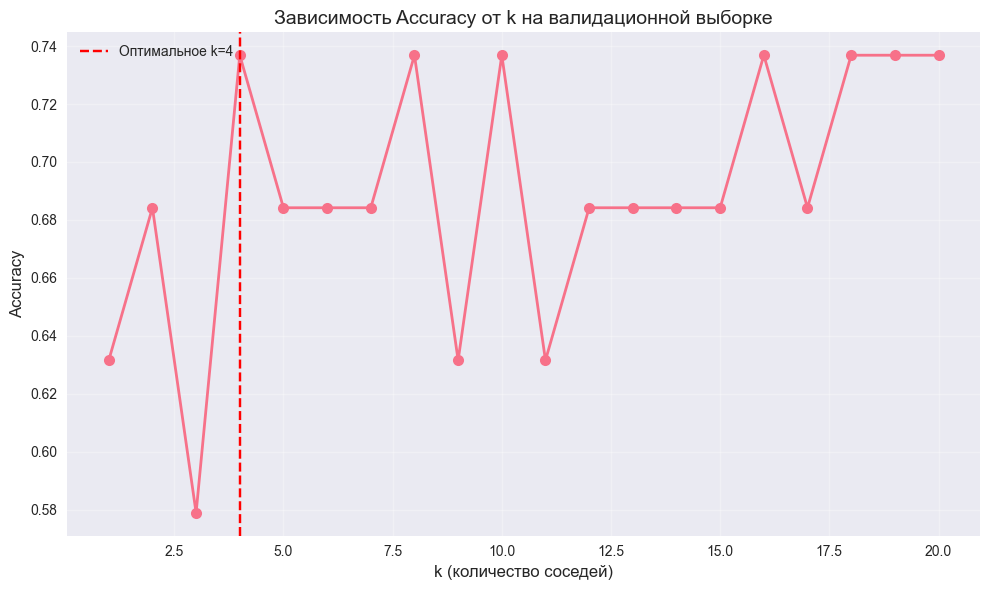

In [170]:
# Подбор оптимального k на валидационной выборке
k_values = range(1, 21)
val_accuracies = []

for k in k_values:
    knn = KNNClassifier(k=k)
    knn.fit(X_train_scaled, y_train)
    y_pred_knn_val = knn.predict(X_val_scaled)
    acc = accuracy_score(y_val, y_pred_knn_val)
    val_accuracies.append(acc)
    print(f"k={k:2d}: Accuracy = {acc:.4f}")

# Находим оптимальное k
best_k_idx = np.argmax(val_accuracies)
best_k = k_values[best_k_idx]
print(f"\nОптимальное k: {best_k} (Accuracy = {val_accuracies[best_k_idx]:.4f})")

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(k_values, val_accuracies, marker='o', linewidth=2, markersize=8)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Оптимальное k={best_k}')
plt.xlabel('k (количество соседей)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Зависимость Accuracy от k на валидационной выборке', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [171]:
# Обучение k-NN с оптимальным k
knn_classifier = KNNClassifier(k=best_k)
knn_classifier.fit(X_train_scaled, y_train)

# Предсказания
y_pred_knn_train = knn_classifier.predict(X_train_scaled)
y_pred_knn_val = knn_classifier.predict(X_val_scaled)
y_pred_knn_test = knn_classifier.predict(X_test_scaled)

# Вероятности для ROC-AUC
y_proba_knn_test = knn_classifier.predict_proba(X_test_scaled)[:, 1]

print(f"k-NN (k={best_k}):")
print(f"Accuracy на train: {accuracy_score(y_train, y_pred_knn_train):.4f}")
print(f"Accuracy на validation: {accuracy_score(y_val, y_pred_knn_val):.4f}")
print(f"Accuracy на test: {accuracy_score(y_test, y_pred_knn_test):.4f}")


k-NN (k=4):
Accuracy на train: 0.7955
Accuracy на validation: 0.7368
Accuracy на test: 0.7000


## 3. Логистическая регрессия


In [172]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, max_iter=1000, tol=1e-6):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None
        self.bias = None
        self.loss_history = []
        
    def sigmoid(self, z):
        """Сигмоидная функция"""
        # Защита от переполнения
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        """Обучение логистической регрессии методом градиентного спуска"""
        n_samples, n_features = X.shape
        
        # Инициализация весов
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = 0.0
        
        # Добавляем единичный столбец для bias
        X_with_bias = np.c_[np.ones(n_samples), X]
        weights_with_bias = np.append(self.bias, self.weights)
        
        for i in range(self.max_iter):
            # Прямой проход
            z = X_with_bias @ weights_with_bias
            h = self.sigmoid(z)
            
            # Вычисление функции потерь (логарифмическая функция потерь)
            loss = -np.mean(y * np.log(h + 1e-10) + (1 - y) * np.log(1 - h + 1e-10))
            self.loss_history.append(loss)
            
            # Обратный проход (градиент)
            gradient = X_with_bias.T @ (h - y) / n_samples
            
            # Обновление весов
            weights_with_bias -= self.learning_rate * gradient
            
            # Проверка сходимости
            if i > 0 and abs(self.loss_history[-2] - self.loss_history[-1]) < self.tol:
                break
        
        self.bias = weights_with_bias[0]
        self.weights = weights_with_bias[1:]
        
        return self
    
    def predict_proba(self, X):
        """Вероятности принадлежности к положительному классу"""
        n_samples = X.shape[0]
        X_with_bias = np.c_[np.ones(n_samples), X]
        weights_with_bias = np.append(self.bias, self.weights)
        z = X_with_bias @ weights_with_bias
        return self.sigmoid(z)
    
    def predict(self, X, threshold=0.5):
        """Предсказание классов"""
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)


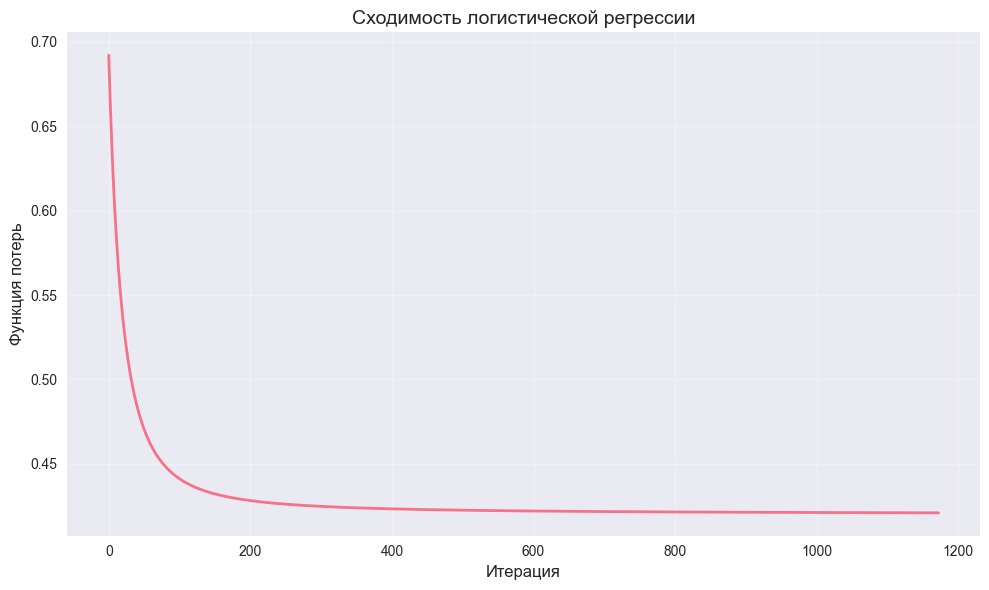

Финальная функция потерь: 0.421022
Количество итераций: 1173


In [173]:
# Обучение логистической регрессии
lr_classifier = LogisticRegression(learning_rate=0.1, max_iter=5000)
lr_classifier.fit(X_train_scaled, y_train)

# Визуализация сходимости
plt.figure(figsize=(10, 6))
plt.plot(lr_classifier.loss_history, linewidth=2)
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Функция потерь', fontsize=12)
plt.title('Сходимость логистической регрессии', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Финальная функция потерь: {lr_classifier.loss_history[-1]:.6f}")
print(f"Количество итераций: {len(lr_classifier.loss_history)}")


Оптимальный порог: 0.2525
F1-score при оптимальном пороге: 0.4286


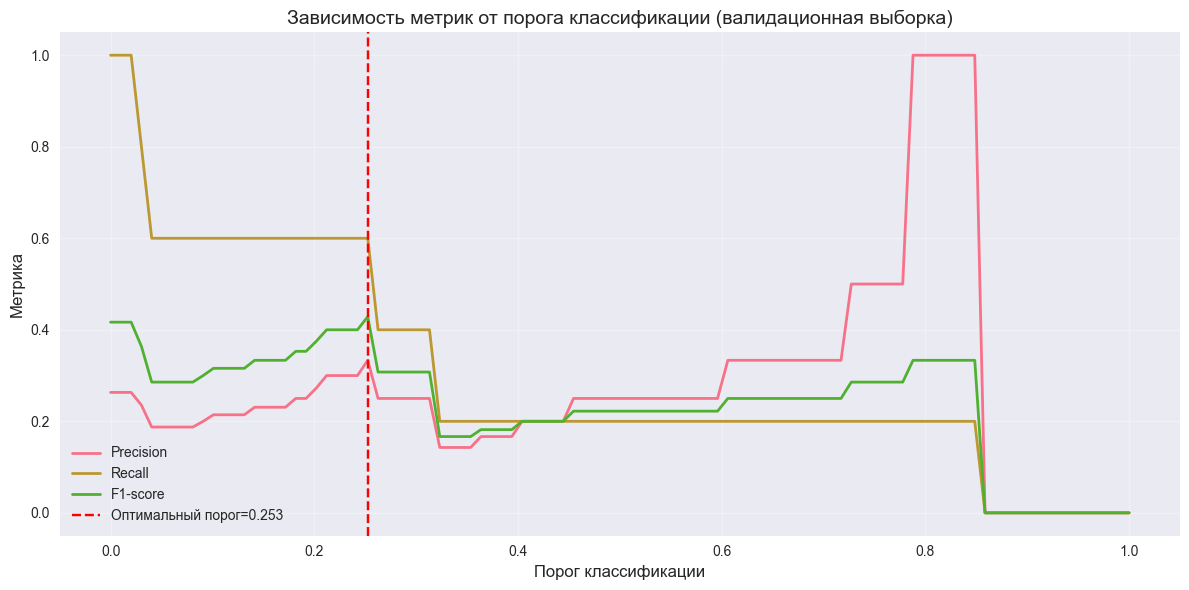

In [174]:
# Получаем вероятности на валидационной выборке
y_proba_lr_val = lr_classifier.predict_proba(X_val_scaled)

# Вычисляем метрики для разных порогов
thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_proba_lr_val >= threshold).astype(int)
    
    if np.sum(y_pred_thresh) == 0:
        prec = 0.0
    else:
        prec = precision_score(y_val, y_pred_thresh, zero_division=0)
    
    rec = recall_score(y_val, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_val, y_pred_thresh, zero_division=0)
    
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)

# Находим оптимальный порог (максимум F1)
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print(f"Оптимальный порог: {best_threshold:.4f}")
print(f"F1-score при оптимальном пороге: {best_f1:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.plot(thresholds, f1_scores, label='F1-score', linewidth=2)
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Оптимальный порог={best_threshold:.3f}')
plt.xlabel('Порог классификации', fontsize=12)
plt.ylabel('Метрика', fontsize=12)
plt.title('Зависимость метрик от порога классификации (валидационная выборка)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [175]:
# Предсказания с оптимальным порогом
y_pred_lr_train = lr_classifier.predict(X_train_scaled, threshold=best_threshold)
y_pred_lr_val = lr_classifier.predict(X_val_scaled, threshold=best_threshold)
y_pred_lr_test = lr_classifier.predict(X_test_scaled, threshold=best_threshold)

# Вероятности для ROC-AUC
y_proba_lr_test = lr_classifier.predict_proba(X_test_scaled)

print(f"Логистическая регрессия (порог={best_threshold:.4f}):")
print(f"Accuracy на train: {accuracy_score(y_train, y_pred_lr_train):.4f}")
print(f"Accuracy на validation: {accuracy_score(y_val, y_pred_lr_val):.4f}")
print(f"Accuracy на test: {accuracy_score(y_test, y_pred_lr_test):.4f}")


Логистическая регрессия (порог=0.2525):
Accuracy на train: 0.7727
Accuracy на validation: 0.5789
Accuracy на test: 0.5500


## 4. Оценка качества моделей на тестовой выборке


In [176]:
# Функция для вычисления всех метрик
def evaluate_model(y_true, y_pred, y_proba=None, model_name=""):
    """Вычисление метрик качества модели"""
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-score': f1_score(y_true, y_pred, zero_division=0)
    }
    
    if y_proba is not None:
        try:
            metrics['ROC-AUC'] = roc_auc_score(y_true, y_proba)
        except:
            metrics['ROC-AUC'] = None
    
    return metrics

# Оценка всех моделей
results = {}

# Тривиальный классификатор
results['Тривиальный'] = evaluate_model(y_test, y_pred_trivial_test, None, "Тривиальный")

# Наивный Байес
results['Наивный Байес'] = evaluate_model(y_test, y_pred_nb_test, y_proba_nb_test, "Наивный Байес")

# k-NN
results['k-NN'] = evaluate_model(y_test, y_pred_knn_test, y_proba_knn_test, "k-NN")

# Логистическая регрессия
results['Логистическая регрессия'] = evaluate_model(y_test, y_pred_lr_test, y_proba_lr_test, "Логистическая регрессия")

print("ОЦЕНКА КАЧЕСТВА МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ")
print(f"{'Модель':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'ROC-AUC':<10}")

for model_name, metrics in results.items():
    roc_auc_str = f"{metrics['ROC-AUC']:.4f}" if metrics.get('ROC-AUC') is not None else "N/A"
    print(f"{model_name:<25} {metrics['Accuracy']:<10.4f} {metrics['Precision']:<10.4f} "
          f"{metrics['Recall']:<10.4f} {metrics['F1-score']:<10.4f} {roc_auc_str:<10}")


ОЦЕНКА КАЧЕСТВА МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ
Модель                    Accuracy   Precision  Recall     F1-score   ROC-AUC   
Тривиальный               0.7500     0.0000     0.0000     0.0000     N/A       
Наивный Байес             0.3000     0.2353     0.8000     0.3636     0.5600    
k-NN                      0.7000     0.3333     0.2000     0.2500     0.5400    
Логистическая регрессия   0.5500     0.2500     0.4000     0.3077     0.5867    


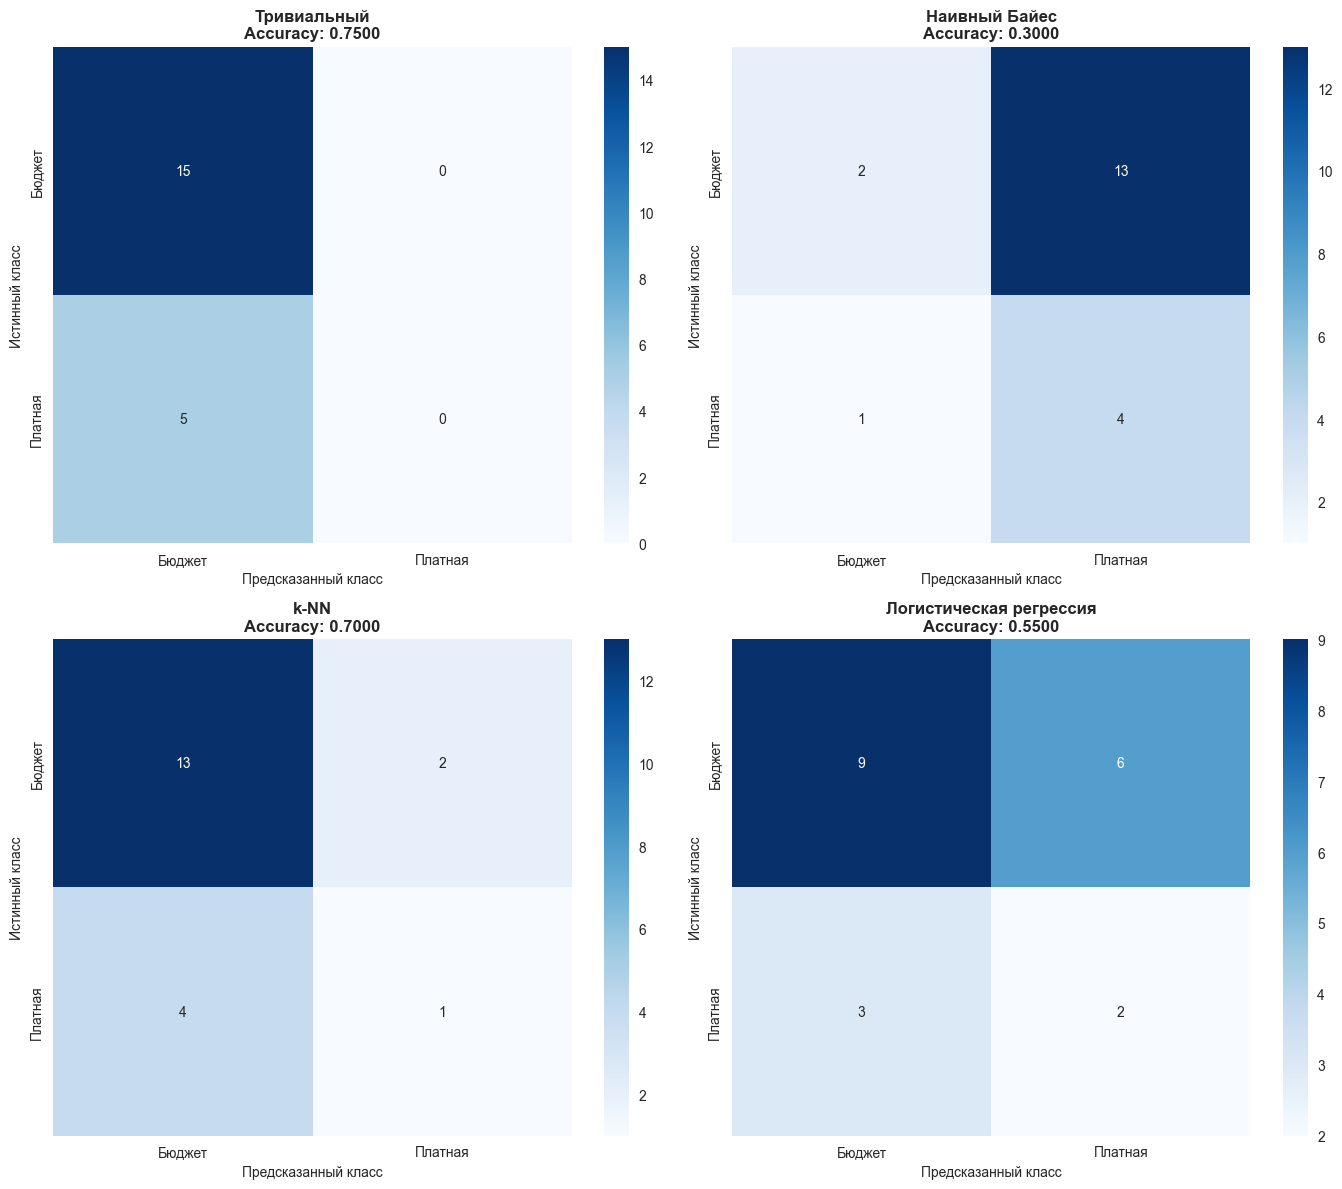

In [177]:
# Матрицы ошибок для всех моделей
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

models = [
    ('Тривиальный', y_pred_trivial_test),
    ('Наивный Байес', y_pred_nb_test),
    ('k-NN', y_pred_knn_test),
    ('Логистическая регрессия', y_pred_lr_test)
]

class_names = le_target.classes_

for idx, (model_name, y_pred) in enumerate(models):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=class_names, yticklabels=class_names)
    axes[idx].set_title(f'{model_name}\nAccuracy: {accuracy_score(y_test, y_pred):.4f}', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Предсказанный класс', fontsize=10)
    axes[idx].set_ylabel('Истинный класс', fontsize=10)

plt.tight_layout()
plt.show()


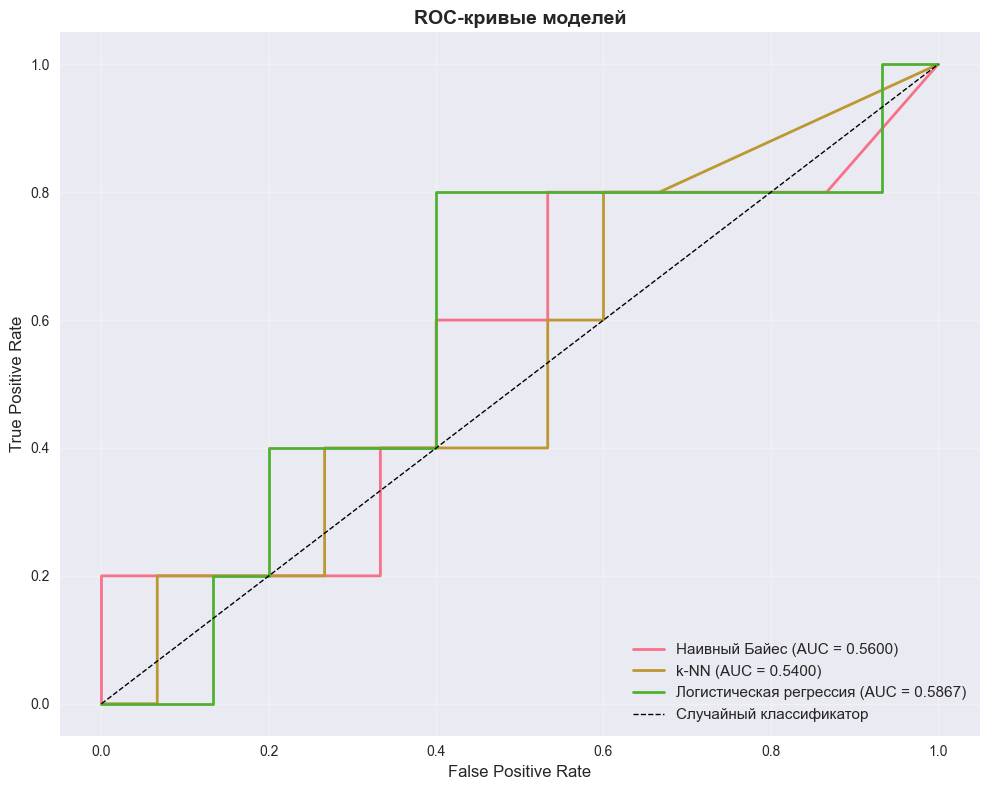

In [178]:
# ROC-кривые для моделей с вероятностями
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))

models_with_proba = [
    ('Наивный Байес', y_proba_nb_test),
    ('k-NN', y_proba_knn_test),
    ('Логистическая регрессия', y_proba_lr_test)
]

for model_name, y_proba in models_with_proba:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Случайный классификатор')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-кривые моделей', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Выводы

### Анализ результатов на тестовой выборке:

#### 1. **Тривиальный классификатор** (Baseline)
- **Accuracy: 0.7500** - показывает наивысшую точность среди всех моделей
- **Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000** - модель не предсказывает класс "Платная" (минорный класс)
- Модель всегда предсказывает класс "Бюджет" (наиболее частый класс), что объясняет высокий accuracy при несбалансированных классах
- **Вывод:** Высокий accuracy не означает хорошее качество модели - это артефакт несбалансированности классов

#### 2. **Наивный байесовский классификатор**
- **Accuracy: 0.3000** - низкая общая точность
- **Precision: 0.2353** - низкая точность предсказаний положительного класса
- **Recall: 0.8000** - высокий показатель полноты (находит 80% объектов класса "Платная")
- **F1-score: 0.3636** - средний баланс между precision и recall
- **ROC-AUC: 0.5600** - немного лучше случайного классификатора (0.5)
- **Вывод:** Модель склонна к переобучению на минорный класс, что приводит к большому количеству ложных срабатываний. Предположение о независимости признаков может не выполняться для данной задачи.

#### 3. **k-NN (k ближайших соседей)**
- **Accuracy: 0.7000** - вторая по точности модель
- **Precision: 0.3333** - умеренная точность
- **Recall: 0.2000** - низкая полнота (находит только 20% объектов класса "Платная")
- **F1-score: 0.2500** - низкий баланс метрик
- **ROC-AUC: 0.5400** - близко к случайному классификатору
- **Вывод:** Модель консервативна в предсказании минорного класса, что приводит к низкому recall. Высокий accuracy достигается за счет правильного предсказания большинства объектов класса "Бюджет".

#### 4. **Логистическая регрессия**
- **Accuracy: 0.5500** - средняя точность
- **Precision: 0.2500** - низкая точность
- **Recall: 0.4000** - средняя полнота
- **F1-score: 0.3077** - средний баланс метрик
- **ROC-AUC: 0.5867** - наилучший показатель среди всех моделей, что указывает на лучшую способность различать классы
- **Вывод:** Модель показывает наиболее сбалансированные результаты и наилучшую способность к разделению классов (наивысший ROC-AUC).

